# Event Propensity : Measuring Performance
* StelllarAlgo Data Science
* Ryan Kazmerik & Joey Lai
* Nov 15, 2022

This notebook attempts to measure the performance of our Event Propensity model scores by comparing each quartile of scores to see how many fans actually purchased for each game

In [ ]:
import awswrangler as wr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from data_sci_toolkit.aws_tools import permission_tools 
from data_sci_toolkit.aws_tools import redshift_tools

/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [3]:
session = permission_tools.get_aws_session("Explore-US-DataScienceAdmin")

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

CRBF-XTPG
Successfully logged into Start URL: https://stellaralgo.awsapps.com/start#/
Authorized as AROASSH5KEZ7FS7KUJUD3:rkazmerik@stellaralgo.com


### Let's load up a list of EP scores for a game from S3:

In [4]:
S3_PATH = "s3://explore-us-curated-data-sci-event-propensity-us-east-1-yvf53s/date=2022-11-04/flames/"

In [5]:
df_scores = wr.s3.read_parquet(boto3_session=session, path=S3_PATH, path_suffix=[".parquet"])
df_scores.shape

(6564480, 13)

### Now we can filter to just get the EP scores for some games that have already happened:

In [6]:
df_scores["eventdate"].value_counts()

2022-11-05    656448
2022-11-12    656448
2022-11-14    656448
2022-11-29    656448
2022-12-01    656448
2022-12-03    656448
2022-12-05    656448
2022-12-07    656448
2022-12-14    656448
2022-12-16    656448
Name: eventdate, dtype: Int64

In [7]:
all_game_dates = df_scores.eventdate.unique()

In [8]:
game_dates = all_game_dates[:3]
game_dates

<StringArray>
['2022-11-05', '2022-11-12', '2022-11-14']
Length: 3, dtype: string

In [9]:
all_scores = []

for idx,game_date in enumerate(game_dates):

    df_temp = df_scores[df_scores["eventdate"] == game_date]
    all_scores.append(df_temp)

    print(f"GAME {idx+1} SCORES: {len(df_temp)}")

GAME 1 SCORES: 656448
GAME 2 SCORES: 656448
GAME 3 SCORES: 656448


### Now we need to get the ticket purchases for those same games:

In [33]:
CLUSTER = "prod-app"
DATABASE = "stlrflames"

In [34]:
conn = redshift_tools.get_redshift_connection(CLUSTER, DATABASE)

all_purchases = []
for idx,game_date in enumerate(game_dates):
    cur = conn.cursor()
    cur.execute(f"""
        SELECT * FROM {DATABASE}.dw.cohortpurchase
        WHERE SPLIT_PART(eventdate, ' ', 1) like '{game_date}'
        AND productgrouping LIKE 'Individual'
    """)

    data = cur.fetchall()

    cols = [row[0] for row in cur.description]
    df_temp = pd.DataFrame(data=data, columns=cols)

    all_purchases.append(df_temp)
    print(f"GAME {idx+1} PURCHASES: {len(df_temp)}")

    conn.commit()

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com
GAME 1 PURCHASES: 2337
GAME 2 PURCHASES: 3431
GAME 3 PURCHASES: 2551


### The EP scores contain 4 scores per customer based on the number of days out from the event. Let's filter the EP scores to only select the highest score for each customer:

In [35]:
filtered_scores = []
for idx,df_scores in enumerate(all_scores):

    df_filtered = df_scores.groupby(['dimcustomermasterid'], sort=False)['sascore'].max()
    filtered_scores.append(df_filtered.to_frame())

    print(f"FILTERED GAME {idx+1} SCORES: {len(df_filtered)}")



FILTERED GAME 1 SCORES: 164112
FILTERED GAME 2 SCORES: 164112
FILTERED GAME 3 SCORES: 164112


### Let's have a look at the EP score distribution for each game:

EP Scores for: stlrflames


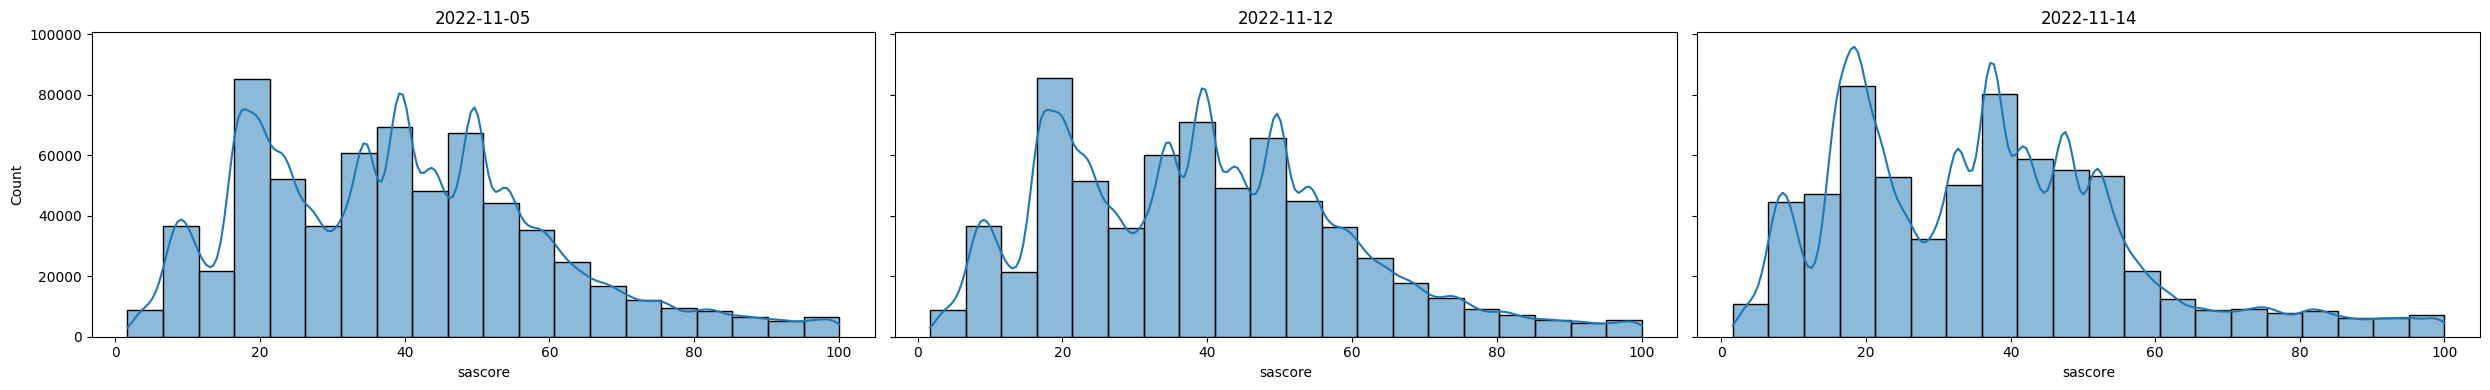

In [39]:
fig, axes = plt.subplots(1, len(all_scores), figsize=(25,4), sharey=True)
for idx, df in enumerate(all_scores):

    sns.histplot(ax=axes[idx], data=df, x='sascore', bins=20, kde=True);
    
    axes[idx].set_title(game_dates[idx])

plt.tight_layout()
print(f"EP Scores for: {DATABASE}")

### Now let's join the EP scores with the ticket purchases for each game:

In [37]:
all_joins = []
for idx, df_filtered_scores in enumerate(filtered_scores):

    df_join = df_filtered_scores.merge(all_purchases[idx], on="dimcustomermasterid", how="inner")
    all_joins.append(df_join)

    print(f"GAME {idx+1} MATCHES: {len(df_join)}")

GAME 1 MATCHES: 1656
GAME 2 MATCHES: 2297
GAME 3 MATCHES: 1737


### Let's plot the matches based on their sascore:

EP Scores for: stlrflames


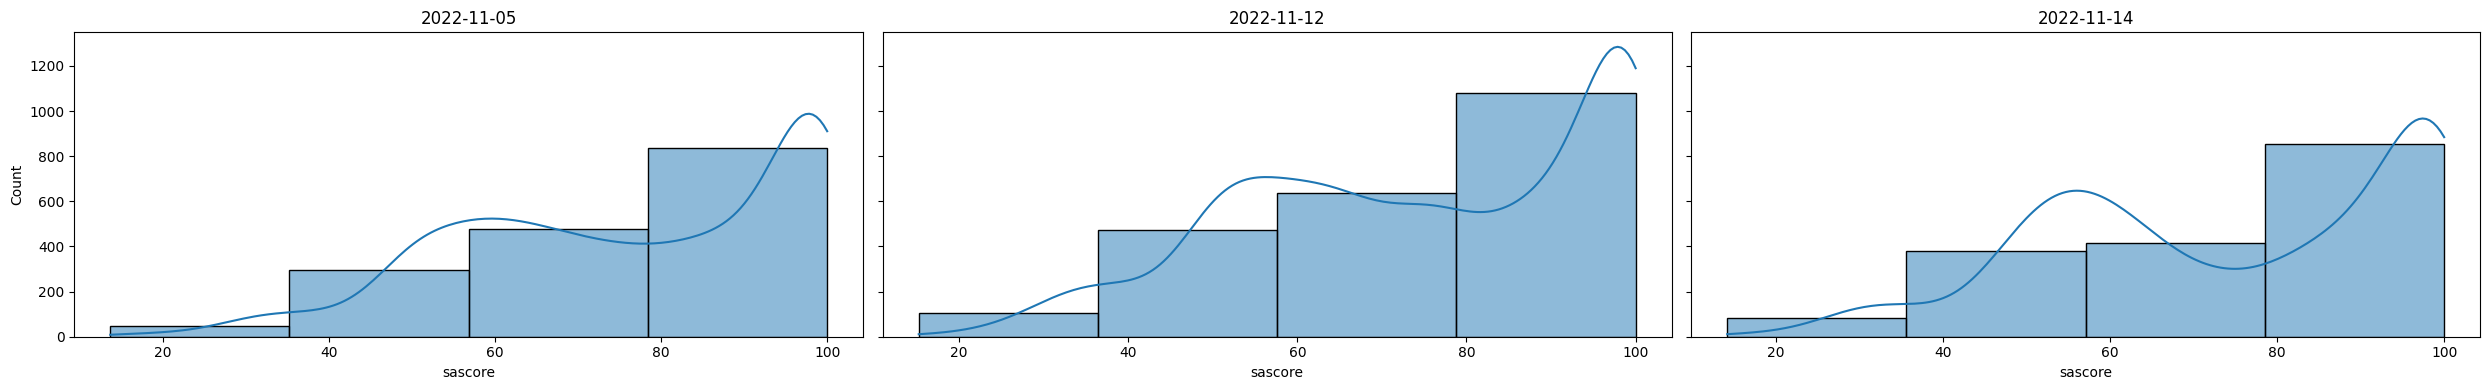

In [38]:
fig, axes = plt.subplots(1, len(all_joins), figsize=(25,4), sharey=True)
for idx, df in enumerate(all_joins):

    sns.histplot(ax=axes[idx], data=df, x='sascore', bins=4, kde=True);
    
    axes[idx].set_title(game_dates[idx])

plt.tight_layout()
print(f"EP Scores for: {DATABASE}")

### As we can see in the charts above, there is a linear relationship between EP score and individual ticket purchases. This suggests that a higher EP score is an indicator that the fan will purchase for the game.  